In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
X_train = datos.loc[rg]
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [5]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [6]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4205, 9)

In [7]:
datos = datos.drop(rg)
datos.shape

(4185, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [189]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [190]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50


In [191]:
G.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_167 (Dense)            (None, 150)               7650      
_________________________________________________________________
dense_168 (Dense)            (None, 9)                 1359      
_________________________________________________________________
reshape_15 (Reshape)         (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [192]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


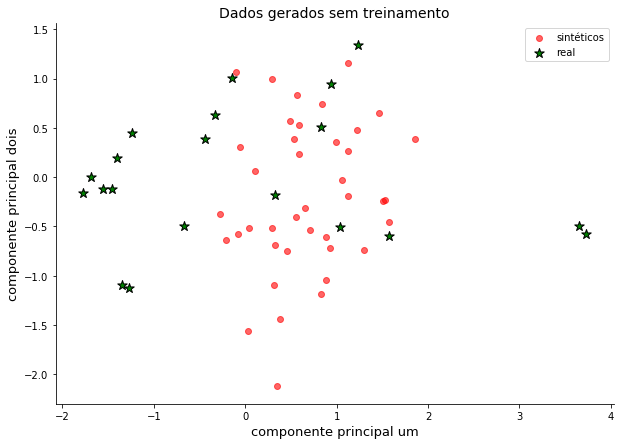

In [193]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [194]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [195]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [196]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [197]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [198]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision

In [230]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/2000)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_80 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_81 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [231]:
ep = 2000
g_loss, d_loss, precision = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.679769],[Generator::loss: 0.685524], 6.894456[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.683832],[Generator::loss: 0.674036], 0.017753[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.695520],[Generator::loss: 0.641052], 0.017671[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.668198],[Generator::loss: 0.673661], 0.017466[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.701058],[Generator::loss: 0.682700], 0.016986[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.687249],[Generator::loss: 0.646009], 0.017362[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.688771],[Generator::loss: 0.647614], 0.018246[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.674701],[Generator::loss: 0.659126], 0.017894[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.709903],[Generator::loss: 0.669490], 0.017310[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.677833],[Generator::loss: 0.719771], 0.017015[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.658971],[Generator::loss: 0.637052], 

epoch:[96/2000] [Discriminator::d_loss: 0.623583],[Generator::loss: 0.688531], 0.021785[sec]
epoch:[97/2000] [Discriminator::d_loss: 0.665531],[Generator::loss: 0.790385], 0.026966[sec]
epoch:[98/2000] [Discriminator::d_loss: 0.655812],[Generator::loss: 0.745474], 0.025205[sec]
epoch:[99/2000] [Discriminator::d_loss: 0.657178],[Generator::loss: 0.717772], 0.019531[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.652408],[Generator::loss: 0.723100], 0.019924[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.588940],[Generator::loss: 0.671264], 0.020305[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.646154],[Generator::loss: 0.756405], 0.027304[sec]
epoch:[103/2000] [Discriminator::d_loss: 0.566770],[Generator::loss: 0.704948], 0.028718[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.639175],[Generator::loss: 0.686599], 0.032564[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.665759],[Generator::loss: 0.664249], 0.032365[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.658480],[Generator::l

epoch:[188/2000] [Discriminator::d_loss: 0.630850],[Generator::loss: 0.719664], 0.022356[sec]
epoch:[189/2000] [Discriminator::d_loss: 0.618092],[Generator::loss: 0.702133], 0.021297[sec]
epoch:[190/2000] [Discriminator::d_loss: 0.623737],[Generator::loss: 0.748453], 0.018939[sec]
epoch:[191/2000] [Discriminator::d_loss: 0.611636],[Generator::loss: 0.717077], 0.018310[sec]
epoch:[192/2000] [Discriminator::d_loss: 0.594802],[Generator::loss: 0.721410], 0.018163[sec]
epoch:[193/2000] [Discriminator::d_loss: 0.599420],[Generator::loss: 0.827741], 0.020326[sec]
epoch:[194/2000] [Discriminator::d_loss: 0.630419],[Generator::loss: 0.738118], 0.018878[sec]
epoch:[195/2000] [Discriminator::d_loss: 0.621829],[Generator::loss: 0.702804], 0.018528[sec]
epoch:[196/2000] [Discriminator::d_loss: 0.625522],[Generator::loss: 0.811919], 0.017509[sec]
epoch:[197/2000] [Discriminator::d_loss: 0.624298],[Generator::loss: 0.761976], 0.017957[sec]
epoch:[198/2000] [Discriminator::d_loss: 0.608051],[Generato

epoch:[279/2000] [Discriminator::d_loss: 0.593704],[Generator::loss: 0.823677], 0.018053[sec]
epoch:[280/2000] [Discriminator::d_loss: 0.589832],[Generator::loss: 0.793120], 0.023141[sec]
epoch:[281/2000] [Discriminator::d_loss: 0.578725],[Generator::loss: 0.807558], 0.018476[sec]
epoch:[282/2000] [Discriminator::d_loss: 0.591283],[Generator::loss: 0.820481], 0.020299[sec]
epoch:[283/2000] [Discriminator::d_loss: 0.615175],[Generator::loss: 0.805283], 0.023237[sec]
epoch:[284/2000] [Discriminator::d_loss: 0.614515],[Generator::loss: 0.757094], 0.029704[sec]
epoch:[285/2000] [Discriminator::d_loss: 0.594024],[Generator::loss: 0.774269], 0.021807[sec]
epoch:[286/2000] [Discriminator::d_loss: 0.622327],[Generator::loss: 0.764260], 0.026941[sec]
epoch:[287/2000] [Discriminator::d_loss: 0.575773],[Generator::loss: 0.796979], 0.021266[sec]
epoch:[288/2000] [Discriminator::d_loss: 0.631270],[Generator::loss: 0.786333], 0.019186[sec]
epoch:[289/2000] [Discriminator::d_loss: 0.580896],[Generato

epoch:[367/2000] [Discriminator::d_loss: 0.589037],[Generator::loss: 0.880418], 0.017993[sec]
epoch:[368/2000] [Discriminator::d_loss: 0.603844],[Generator::loss: 0.760073], 0.021358[sec]
epoch:[369/2000] [Discriminator::d_loss: 0.617305],[Generator::loss: 0.813820], 0.018391[sec]
epoch:[370/2000] [Discriminator::d_loss: 0.555071],[Generator::loss: 0.830883], 0.025368[sec]
epoch:[371/2000] [Discriminator::d_loss: 0.562177],[Generator::loss: 0.795015], 0.018055[sec]
epoch:[372/2000] [Discriminator::d_loss: 0.570011],[Generator::loss: 0.840521], 0.017993[sec]
epoch:[373/2000] [Discriminator::d_loss: 0.561475],[Generator::loss: 0.920641], 0.018335[sec]
epoch:[374/2000] [Discriminator::d_loss: 0.552305],[Generator::loss: 0.787663], 0.018059[sec]
epoch:[375/2000] [Discriminator::d_loss: 0.594293],[Generator::loss: 0.790879], 0.017930[sec]
epoch:[376/2000] [Discriminator::d_loss: 0.564102],[Generator::loss: 0.807791], 0.017859[sec]
epoch:[377/2000] [Discriminator::d_loss: 0.595688],[Generato

epoch:[455/2000] [Discriminator::d_loss: 0.543108],[Generator::loss: 0.845852], 0.028466[sec]
epoch:[456/2000] [Discriminator::d_loss: 0.592108],[Generator::loss: 0.839665], 0.029913[sec]
epoch:[457/2000] [Discriminator::d_loss: 0.584580],[Generator::loss: 0.840063], 0.018403[sec]
epoch:[458/2000] [Discriminator::d_loss: 0.561914],[Generator::loss: 0.854486], 0.017328[sec]
epoch:[459/2000] [Discriminator::d_loss: 0.563221],[Generator::loss: 0.873928], 0.017581[sec]
epoch:[460/2000] [Discriminator::d_loss: 0.574392],[Generator::loss: 0.854469], 0.016916[sec]
epoch:[461/2000] [Discriminator::d_loss: 0.584567],[Generator::loss: 0.850372], 0.018646[sec]
epoch:[462/2000] [Discriminator::d_loss: 0.570778],[Generator::loss: 0.909381], 0.018810[sec]
epoch:[463/2000] [Discriminator::d_loss: 0.586220],[Generator::loss: 0.832635], 0.017973[sec]
epoch:[464/2000] [Discriminator::d_loss: 0.566145],[Generator::loss: 0.796996], 0.016535[sec]
epoch:[465/2000] [Discriminator::d_loss: 0.593060],[Generato

epoch:[550/2000] [Discriminator::d_loss: 0.575941],[Generator::loss: 0.833097], 0.016774[sec]
epoch:[551/2000] [Discriminator::d_loss: 0.572354],[Generator::loss: 0.810142], 0.018697[sec]
epoch:[552/2000] [Discriminator::d_loss: 0.592171],[Generator::loss: 0.898238], 0.015981[sec]
epoch:[553/2000] [Discriminator::d_loss: 0.547636],[Generator::loss: 0.722172], 0.015843[sec]
epoch:[554/2000] [Discriminator::d_loss: 0.547299],[Generator::loss: 0.803696], 0.015820[sec]
epoch:[555/2000] [Discriminator::d_loss: 0.571433],[Generator::loss: 0.860503], 0.015942[sec]
epoch:[556/2000] [Discriminator::d_loss: 0.574675],[Generator::loss: 0.909004], 0.015513[sec]
epoch:[557/2000] [Discriminator::d_loss: 0.617151],[Generator::loss: 0.960766], 0.015531[sec]
epoch:[558/2000] [Discriminator::d_loss: 0.546732],[Generator::loss: 0.826970], 0.015659[sec]
epoch:[559/2000] [Discriminator::d_loss: 0.569637],[Generator::loss: 0.821037], 0.015447[sec]
epoch:[560/2000] [Discriminator::d_loss: 0.528385],[Generato

epoch:[638/2000] [Discriminator::d_loss: 0.537416],[Generator::loss: 0.782760], 0.020419[sec]
epoch:[639/2000] [Discriminator::d_loss: 0.578628],[Generator::loss: 0.884825], 0.029512[sec]
epoch:[640/2000] [Discriminator::d_loss: 0.556010],[Generator::loss: 0.900435], 0.021137[sec]
epoch:[641/2000] [Discriminator::d_loss: 0.619685],[Generator::loss: 0.799183], 0.022015[sec]
epoch:[642/2000] [Discriminator::d_loss: 0.592007],[Generator::loss: 0.929276], 0.019872[sec]
epoch:[643/2000] [Discriminator::d_loss: 0.556593],[Generator::loss: 0.839452], 0.018193[sec]
epoch:[644/2000] [Discriminator::d_loss: 0.577004],[Generator::loss: 0.846668], 0.019100[sec]
epoch:[645/2000] [Discriminator::d_loss: 0.588654],[Generator::loss: 0.845372], 0.018183[sec]
epoch:[646/2000] [Discriminator::d_loss: 0.642320],[Generator::loss: 0.847350], 0.019201[sec]
epoch:[647/2000] [Discriminator::d_loss: 0.561300],[Generator::loss: 0.926958], 0.018110[sec]
epoch:[648/2000] [Discriminator::d_loss: 0.609387],[Generato

epoch:[730/2000] [Discriminator::d_loss: 0.594666],[Generator::loss: 0.905265], 0.017979[sec]
epoch:[731/2000] [Discriminator::d_loss: 0.637982],[Generator::loss: 0.882964], 0.018300[sec]
epoch:[732/2000] [Discriminator::d_loss: 0.594185],[Generator::loss: 0.848698], 0.016670[sec]
epoch:[733/2000] [Discriminator::d_loss: 0.569481],[Generator::loss: 0.876135], 0.016889[sec]
epoch:[734/2000] [Discriminator::d_loss: 0.614074],[Generator::loss: 0.776590], 0.015772[sec]
epoch:[735/2000] [Discriminator::d_loss: 0.587056],[Generator::loss: 0.728949], 0.015944[sec]
epoch:[736/2000] [Discriminator::d_loss: 0.639829],[Generator::loss: 0.780859], 0.018569[sec]
epoch:[737/2000] [Discriminator::d_loss: 0.634628],[Generator::loss: 0.776094], 0.020602[sec]
epoch:[738/2000] [Discriminator::d_loss: 0.578346],[Generator::loss: 0.888742], 0.021731[sec]
epoch:[739/2000] [Discriminator::d_loss: 0.597777],[Generator::loss: 0.682042], 0.016508[sec]
epoch:[740/2000] [Discriminator::d_loss: 0.605722],[Generato

epoch:[818/2000] [Discriminator::d_loss: 0.611730],[Generator::loss: 0.795751], 0.023621[sec]
epoch:[819/2000] [Discriminator::d_loss: 0.591998],[Generator::loss: 0.726673], 0.017834[sec]
epoch:[820/2000] [Discriminator::d_loss: 0.613420],[Generator::loss: 0.845198], 0.019118[sec]
epoch:[821/2000] [Discriminator::d_loss: 0.666000],[Generator::loss: 0.880956], 0.020115[sec]
epoch:[822/2000] [Discriminator::d_loss: 0.631239],[Generator::loss: 0.900658], 0.018652[sec]
epoch:[823/2000] [Discriminator::d_loss: 0.585684],[Generator::loss: 0.811392], 0.016964[sec]
epoch:[824/2000] [Discriminator::d_loss: 0.634484],[Generator::loss: 0.801562], 0.019180[sec]
epoch:[825/2000] [Discriminator::d_loss: 0.652937],[Generator::loss: 0.721594], 0.019198[sec]
epoch:[826/2000] [Discriminator::d_loss: 0.588841],[Generator::loss: 0.888341], 0.018441[sec]
epoch:[827/2000] [Discriminator::d_loss: 0.609136],[Generator::loss: 0.889705], 0.019707[sec]
epoch:[828/2000] [Discriminator::d_loss: 0.594175],[Generato

epoch:[915/2000] [Discriminator::d_loss: 0.729425],[Generator::loss: 0.850694], 0.017399[sec]
epoch:[916/2000] [Discriminator::d_loss: 0.677643],[Generator::loss: 0.773972], 0.021376[sec]
epoch:[917/2000] [Discriminator::d_loss: 0.679784],[Generator::loss: 0.867205], 0.017251[sec]
epoch:[918/2000] [Discriminator::d_loss: 0.672903],[Generator::loss: 0.823967], 0.016142[sec]
epoch:[919/2000] [Discriminator::d_loss: 0.653273],[Generator::loss: 0.887938], 0.015552[sec]
epoch:[920/2000] [Discriminator::d_loss: 0.646404],[Generator::loss: 0.725479], 0.015638[sec]
epoch:[921/2000] [Discriminator::d_loss: 0.656994],[Generator::loss: 0.779829], 0.015668[sec]
epoch:[922/2000] [Discriminator::d_loss: 0.714803],[Generator::loss: 0.807576], 0.016319[sec]
epoch:[923/2000] [Discriminator::d_loss: 0.632606],[Generator::loss: 0.840120], 0.016665[sec]
epoch:[924/2000] [Discriminator::d_loss: 0.667603],[Generator::loss: 0.836681], 0.016870[sec]
epoch:[925/2000] [Discriminator::d_loss: 0.661466],[Generato

epoch:[1015/2000] [Discriminator::d_loss: 0.704677],[Generator::loss: 0.854462], 0.017931[sec]
epoch:[1016/2000] [Discriminator::d_loss: 0.675111],[Generator::loss: 0.780333], 0.017901[sec]
epoch:[1017/2000] [Discriminator::d_loss: 0.641330],[Generator::loss: 0.774455], 0.016853[sec]
epoch:[1018/2000] [Discriminator::d_loss: 0.676981],[Generator::loss: 0.888178], 0.016662[sec]
epoch:[1019/2000] [Discriminator::d_loss: 0.698574],[Generator::loss: 0.728889], 0.025459[sec]
epoch:[1020/2000] [Discriminator::d_loss: 0.638034],[Generator::loss: 0.873253], 0.021473[sec]
epoch:[1021/2000] [Discriminator::d_loss: 0.698524],[Generator::loss: 0.752848], 0.022005[sec]
epoch:[1022/2000] [Discriminator::d_loss: 0.642800],[Generator::loss: 0.791546], 0.026183[sec]
epoch:[1023/2000] [Discriminator::d_loss: 0.674532],[Generator::loss: 0.752467], 0.023126[sec]
epoch:[1024/2000] [Discriminator::d_loss: 0.696606],[Generator::loss: 0.726053], 0.024279[sec]
epoch:[1025/2000] [Discriminator::d_loss: 0.679374

epoch:[1108/2000] [Discriminator::d_loss: 0.642941],[Generator::loss: 0.759717], 0.018458[sec]
epoch:[1109/2000] [Discriminator::d_loss: 0.749372],[Generator::loss: 0.660740], 0.016705[sec]
epoch:[1110/2000] [Discriminator::d_loss: 0.626854],[Generator::loss: 0.699874], 0.018730[sec]
epoch:[1111/2000] [Discriminator::d_loss: 0.672694],[Generator::loss: 0.760176], 0.016164[sec]
epoch:[1112/2000] [Discriminator::d_loss: 0.730839],[Generator::loss: 0.833777], 0.015562[sec]
epoch:[1113/2000] [Discriminator::d_loss: 0.666258],[Generator::loss: 0.775650], 0.015301[sec]
epoch:[1114/2000] [Discriminator::d_loss: 0.677724],[Generator::loss: 0.740179], 0.015700[sec]
epoch:[1115/2000] [Discriminator::d_loss: 0.709143],[Generator::loss: 0.742613], 0.015915[sec]
epoch:[1116/2000] [Discriminator::d_loss: 0.729133],[Generator::loss: 0.733420], 0.015852[sec]
epoch:[1117/2000] [Discriminator::d_loss: 0.756097],[Generator::loss: 0.734302], 0.015673[sec]
epoch:[1118/2000] [Discriminator::d_loss: 0.733489

epoch:[1201/2000] [Discriminator::d_loss: 0.732333],[Generator::loss: 0.839076], 0.017309[sec]
epoch:[1202/2000] [Discriminator::d_loss: 0.745471],[Generator::loss: 0.773241], 0.017410[sec]
epoch:[1203/2000] [Discriminator::d_loss: 0.642866],[Generator::loss: 0.764207], 0.015794[sec]
epoch:[1204/2000] [Discriminator::d_loss: 0.735062],[Generator::loss: 0.710383], 0.015571[sec]
epoch:[1205/2000] [Discriminator::d_loss: 0.762224],[Generator::loss: 0.835634], 0.015527[sec]
epoch:[1206/2000] [Discriminator::d_loss: 0.699243],[Generator::loss: 0.729006], 0.015852[sec]
epoch:[1207/2000] [Discriminator::d_loss: 0.713659],[Generator::loss: 0.757528], 0.015630[sec]
epoch:[1208/2000] [Discriminator::d_loss: 0.672694],[Generator::loss: 0.674653], 0.015289[sec]
epoch:[1209/2000] [Discriminator::d_loss: 0.738278],[Generator::loss: 0.750596], 0.015479[sec]
epoch:[1210/2000] [Discriminator::d_loss: 0.754062],[Generator::loss: 0.778400], 0.015598[sec]
epoch:[1211/2000] [Discriminator::d_loss: 0.725969

epoch:[1290/2000] [Discriminator::d_loss: 0.699362],[Generator::loss: 0.814344], 0.016524[sec]
epoch:[1291/2000] [Discriminator::d_loss: 0.715673],[Generator::loss: 0.855852], 0.017840[sec]
epoch:[1292/2000] [Discriminator::d_loss: 0.665562],[Generator::loss: 0.704801], 0.015877[sec]
epoch:[1293/2000] [Discriminator::d_loss: 0.720534],[Generator::loss: 0.713363], 0.015468[sec]
epoch:[1294/2000] [Discriminator::d_loss: 0.698106],[Generator::loss: 0.754885], 0.015739[sec]
epoch:[1295/2000] [Discriminator::d_loss: 0.677936],[Generator::loss: 0.758545], 0.015595[sec]
epoch:[1296/2000] [Discriminator::d_loss: 0.718093],[Generator::loss: 0.800538], 0.015414[sec]
epoch:[1297/2000] [Discriminator::d_loss: 0.719194],[Generator::loss: 0.811240], 0.019644[sec]
epoch:[1298/2000] [Discriminator::d_loss: 0.740476],[Generator::loss: 0.759074], 0.016134[sec]
epoch:[1299/2000] [Discriminator::d_loss: 0.648874],[Generator::loss: 0.723533], 0.015575[sec]
epoch:[1300/2000] [Discriminator::d_loss: 0.697735

epoch:[1381/2000] [Discriminator::d_loss: 0.724572],[Generator::loss: 0.768848], 0.021417[sec]
epoch:[1382/2000] [Discriminator::d_loss: 0.719060],[Generator::loss: 0.760977], 0.017441[sec]
epoch:[1383/2000] [Discriminator::d_loss: 0.719928],[Generator::loss: 0.781474], 0.015810[sec]
epoch:[1384/2000] [Discriminator::d_loss: 0.672558],[Generator::loss: 0.741460], 0.015412[sec]
epoch:[1385/2000] [Discriminator::d_loss: 0.717465],[Generator::loss: 0.807232], 0.015459[sec]
epoch:[1386/2000] [Discriminator::d_loss: 0.723159],[Generator::loss: 0.793544], 0.015452[sec]
epoch:[1387/2000] [Discriminator::d_loss: 0.697971],[Generator::loss: 0.661509], 0.015735[sec]
epoch:[1388/2000] [Discriminator::d_loss: 0.727132],[Generator::loss: 0.760822], 0.015636[sec]
epoch:[1389/2000] [Discriminator::d_loss: 0.715329],[Generator::loss: 0.748061], 0.015790[sec]
epoch:[1390/2000] [Discriminator::d_loss: 0.732107],[Generator::loss: 0.714881], 0.015592[sec]
epoch:[1391/2000] [Discriminator::d_loss: 0.751931

epoch:[1472/2000] [Discriminator::d_loss: 0.679240],[Generator::loss: 0.755029], 0.017297[sec]
epoch:[1473/2000] [Discriminator::d_loss: 0.715015],[Generator::loss: 0.770545], 0.021161[sec]
epoch:[1474/2000] [Discriminator::d_loss: 0.729502],[Generator::loss: 0.741427], 0.016155[sec]
epoch:[1475/2000] [Discriminator::d_loss: 0.699950],[Generator::loss: 0.740901], 0.015552[sec]
epoch:[1476/2000] [Discriminator::d_loss: 0.712181],[Generator::loss: 0.768844], 0.015199[sec]
epoch:[1477/2000] [Discriminator::d_loss: 0.721265],[Generator::loss: 0.759390], 0.015603[sec]
epoch:[1478/2000] [Discriminator::d_loss: 0.706626],[Generator::loss: 0.722670], 0.015363[sec]
epoch:[1479/2000] [Discriminator::d_loss: 0.700354],[Generator::loss: 0.771572], 0.015736[sec]
epoch:[1480/2000] [Discriminator::d_loss: 0.716126],[Generator::loss: 0.716996], 0.015748[sec]
epoch:[1481/2000] [Discriminator::d_loss: 0.712708],[Generator::loss: 0.756122], 0.015676[sec]
epoch:[1482/2000] [Discriminator::d_loss: 0.686028

epoch:[1563/2000] [Discriminator::d_loss: 0.710980],[Generator::loss: 0.749211], 0.017104[sec]
epoch:[1564/2000] [Discriminator::d_loss: 0.684223],[Generator::loss: 0.754110], 0.020936[sec]
epoch:[1565/2000] [Discriminator::d_loss: 0.700938],[Generator::loss: 0.701598], 0.016458[sec]
epoch:[1566/2000] [Discriminator::d_loss: 0.711638],[Generator::loss: 0.741376], 0.015487[sec]
epoch:[1567/2000] [Discriminator::d_loss: 0.684508],[Generator::loss: 0.717051], 0.015276[sec]
epoch:[1568/2000] [Discriminator::d_loss: 0.700251],[Generator::loss: 0.732279], 0.015803[sec]
epoch:[1569/2000] [Discriminator::d_loss: 0.703895],[Generator::loss: 0.714298], 0.015133[sec]
epoch:[1570/2000] [Discriminator::d_loss: 0.705891],[Generator::loss: 0.741074], 0.015441[sec]
epoch:[1571/2000] [Discriminator::d_loss: 0.714420],[Generator::loss: 0.729905], 0.015277[sec]
epoch:[1572/2000] [Discriminator::d_loss: 0.756955],[Generator::loss: 0.711741], 0.015445[sec]
epoch:[1573/2000] [Discriminator::d_loss: 0.705075

epoch:[1654/2000] [Discriminator::d_loss: 0.708091],[Generator::loss: 0.708134], 0.019877[sec]
epoch:[1655/2000] [Discriminator::d_loss: 0.712950],[Generator::loss: 0.757875], 0.016202[sec]
epoch:[1656/2000] [Discriminator::d_loss: 0.684438],[Generator::loss: 0.692750], 0.015727[sec]
epoch:[1657/2000] [Discriminator::d_loss: 0.695499],[Generator::loss: 0.744204], 0.015148[sec]
epoch:[1658/2000] [Discriminator::d_loss: 0.697317],[Generator::loss: 0.714552], 0.015321[sec]
epoch:[1659/2000] [Discriminator::d_loss: 0.695939],[Generator::loss: 0.699784], 0.015095[sec]
epoch:[1660/2000] [Discriminator::d_loss: 0.669357],[Generator::loss: 0.740023], 0.015692[sec]
epoch:[1661/2000] [Discriminator::d_loss: 0.703713],[Generator::loss: 0.676799], 0.015310[sec]
epoch:[1662/2000] [Discriminator::d_loss: 0.709973],[Generator::loss: 0.699361], 0.015538[sec]
epoch:[1663/2000] [Discriminator::d_loss: 0.727640],[Generator::loss: 0.688549], 0.015500[sec]
epoch:[1664/2000] [Discriminator::d_loss: 0.703293

epoch:[1744/2000] [Discriminator::d_loss: 0.705460],[Generator::loss: 0.741738], 0.016115[sec]
epoch:[1745/2000] [Discriminator::d_loss: 0.674096],[Generator::loss: 0.723822], 0.018818[sec]
epoch:[1746/2000] [Discriminator::d_loss: 0.694980],[Generator::loss: 0.709528], 0.015691[sec]
epoch:[1747/2000] [Discriminator::d_loss: 0.686520],[Generator::loss: 0.745058], 0.015915[sec]
epoch:[1748/2000] [Discriminator::d_loss: 0.718170],[Generator::loss: 0.724676], 0.015179[sec]
epoch:[1749/2000] [Discriminator::d_loss: 0.708512],[Generator::loss: 0.742350], 0.015415[sec]
epoch:[1750/2000] [Discriminator::d_loss: 0.693832],[Generator::loss: 0.734616], 0.015894[sec]
epoch:[1751/2000] [Discriminator::d_loss: 0.666155],[Generator::loss: 0.701453], 0.016428[sec]
epoch:[1752/2000] [Discriminator::d_loss: 0.650442],[Generator::loss: 0.706342], 0.015980[sec]
epoch:[1753/2000] [Discriminator::d_loss: 0.689456],[Generator::loss: 0.691055], 0.015244[sec]
epoch:[1754/2000] [Discriminator::d_loss: 0.672167

epoch:[1835/2000] [Discriminator::d_loss: 0.687118],[Generator::loss: 0.708006], 0.018681[sec]
epoch:[1836/2000] [Discriminator::d_loss: 0.689830],[Generator::loss: 0.761494], 0.016285[sec]
epoch:[1837/2000] [Discriminator::d_loss: 0.687828],[Generator::loss: 0.705748], 0.015255[sec]
epoch:[1838/2000] [Discriminator::d_loss: 0.673077],[Generator::loss: 0.730549], 0.015363[sec]
epoch:[1839/2000] [Discriminator::d_loss: 0.688392],[Generator::loss: 0.743651], 0.015337[sec]
epoch:[1840/2000] [Discriminator::d_loss: 0.669688],[Generator::loss: 0.754753], 0.015593[sec]
epoch:[1841/2000] [Discriminator::d_loss: 0.719453],[Generator::loss: 0.769443], 0.015276[sec]
epoch:[1842/2000] [Discriminator::d_loss: 0.691823],[Generator::loss: 0.706575], 0.015073[sec]
epoch:[1843/2000] [Discriminator::d_loss: 0.664159],[Generator::loss: 0.699885], 0.015039[sec]
epoch:[1844/2000] [Discriminator::d_loss: 0.664063],[Generator::loss: 0.732821], 0.015283[sec]
epoch:[1845/2000] [Discriminator::d_loss: 0.688110

epoch:[1926/2000] [Discriminator::d_loss: 0.696980],[Generator::loss: 0.701975], 0.020619[sec]
epoch:[1927/2000] [Discriminator::d_loss: 0.692010],[Generator::loss: 0.719441], 0.017743[sec]
epoch:[1928/2000] [Discriminator::d_loss: 0.683598],[Generator::loss: 0.685143], 0.015531[sec]
epoch:[1929/2000] [Discriminator::d_loss: 0.685323],[Generator::loss: 0.749392], 0.015511[sec]
epoch:[1930/2000] [Discriminator::d_loss: 0.685801],[Generator::loss: 0.754492], 0.015070[sec]
epoch:[1931/2000] [Discriminator::d_loss: 0.700872],[Generator::loss: 0.717175], 0.015599[sec]
epoch:[1932/2000] [Discriminator::d_loss: 0.715752],[Generator::loss: 0.718870], 0.015275[sec]
epoch:[1933/2000] [Discriminator::d_loss: 0.691922],[Generator::loss: 0.768654], 0.015080[sec]
epoch:[1934/2000] [Discriminator::d_loss: 0.711321],[Generator::loss: 0.715885], 0.015205[sec]
epoch:[1935/2000] [Discriminator::d_loss: 0.688027],[Generator::loss: 0.705594], 0.015039[sec]
epoch:[1936/2000] [Discriminator::d_loss: 0.706917

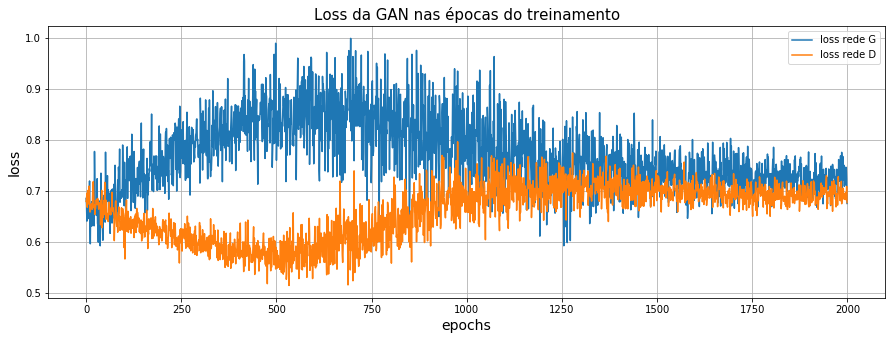

In [232]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

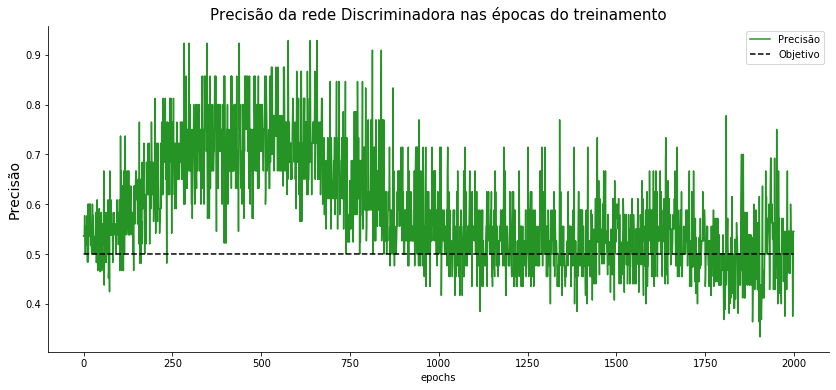

In [233]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

(20, 2) (300, 2)


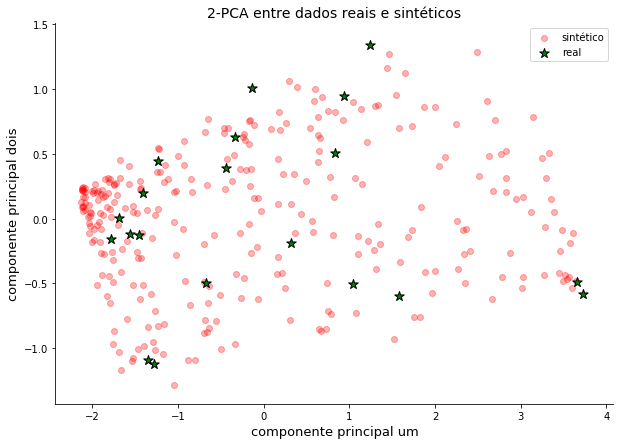

In [240]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [241]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(precision_score(y_test, y_predict))

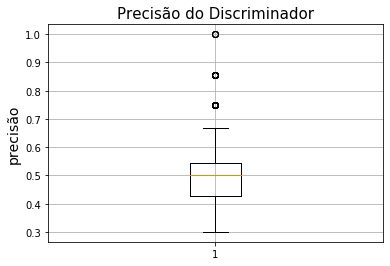

In [242]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [243]:
np.mean(score), np.std(score), np.median(score)

(0.4964719217624481, 0.08824206219406722, 0.5)

In [244]:
X_train.shape

(20, 9)

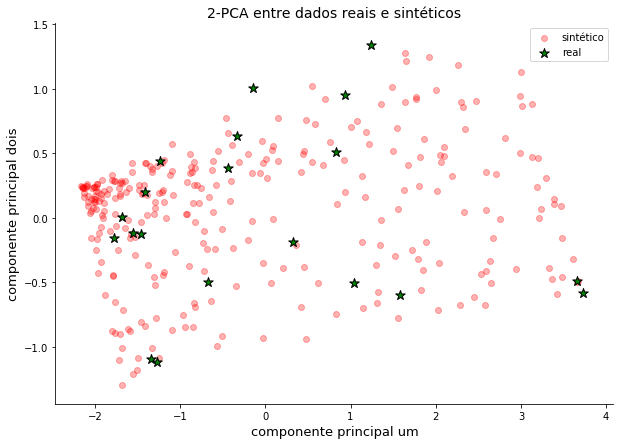

In [247]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train.iloc[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [248]:
X_nov.shape

(314, 9)

### One-class classification with SVM

In [260]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.0121, gamma=.1).fit(X_nov)

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train.iloc[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train.iloc[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9840764331210191
score nos genes de referência de treinamento:  0.9285714285714286
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.9


In [261]:
#gan.save("./data/best_gan.h5")

In [262]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [263]:
predict_cand = clf.predict(datos)

In [264]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]
cand.shape, no_cand.shape

((996, 9), (3189, 9))

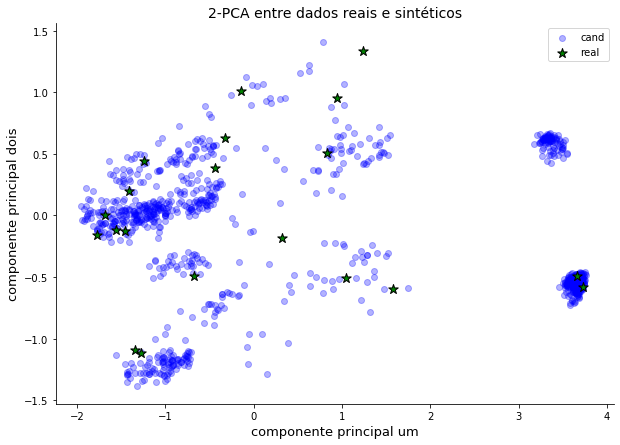

In [265]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [266]:
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

redução do  76.20071684587813 % no processo de escolha de candidatos


In [267]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [268]:
datos.loc[cand.loc[rg_moose].dropna().index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [269]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [270]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [271]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


In [272]:
class one_class_gan:
    
    def __init__(self, X_train, noise_input, epochs):
        self.X_train = X_train
        self.noise_input = noise_input
        self.epochs = epochs
        #building gan
        optG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/self.epochs)
        optD = SGD(lr=0.00021, momentum=0.92, decay=0.0001/self.epochs)
        self.G = self.generator(optG)
        self.D = self.discriminator(optD)
        self.gan = self.build_gan(self.G, self.D, optG) 
        
    def generator(self, opt):
        model = Sequential()
        model.add(Dense(30, input_shape=(self.noise_input,)))
        model.add(Dense(30))
        model.add(Dense(X_train.shape[1], activation="tanh"))
        model.compile(loss="binary_crossentropy",
                      optimizer=opt)
        return model
    
    def discriminator(self, opt):
        model = Sequential()
        model.add(Dense(128, input_shape=(self.X_train.shape[1],)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(64))
        #model.add(Dropout(.1))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
        return model
    
    def build_gan(self, G, D, opt):
        model = Sequential()
        model.add(G)
        D.trainable = False
        model.add(D)
        model.compile(loss="binary_crossentropy", optimizer=opt)
        return model
        
    def get_batches(self, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(self.X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > self.X_train.shape[0]:
                lim_s = self.X_train.shape[0]
            batches.append(self.X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
        return batches

    def train(self, epochs, batch_size):       
        g_loss = []
        d_loss = []
        precision = []
        for epoch in range(epochs):
            batches = self.get_batches(batch_size)
            count_b = 0
            t_i = time()
            d_bacth_loss = []
            g_bacth_loss = []
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_data = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_data))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_bacth_loss.append(self.D.train_on_batch(x_combined_batch, y_combined_batch)[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))
                g_bacth_loss.append(self.gan.train_on_batch(noise, y_mislabled))

            #precision
            X_sint = self.G.predict(np.random.normal(0, 1, (self.X_train.shape[0], self.noise_input)))
            X_comb = np.concatenate((self.X_train, X_sint))
            y_comb = np.concatenate((np.ones((self.X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
            y_predict = self.D.predict_classes(X_comb)
            #f1_lag = f1_score(y_test, y_predict)
            precision.append(precision_score(y_comb, y_predict))
            #fscore.append(f1_lag)
            t_f = time()
            t = t_f - t_i
            t_i = time()
            #d_loss.append(np.mean(np.array(d_bacth_loss)))
            #g_loss.append(np.mean(np.array(g_bacth_loss)))
            d_loss.append(d_bacth_loss[-1])
            g_loss.append(g_bacth_loss[-1])
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                       % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
            #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
            #    break
        return g_loss, d_loss, precision

In [273]:
X_nov.shape

(314, 9)

In [278]:
obj_oc = one_class_gan(X_nov, 50, 1000)
gloss, dloss, d_precision  = obj_oc.train(1000, batch_size=int(X_nov.shape[0]))

epoch:[1/1000] [Discriminator::d_loss: 0.756546],[Generator::loss: 0.719846], 7.172404[sec]
epoch:[2/1000] [Discriminator::d_loss: 0.754992],[Generator::loss: 0.712429], 0.059771[sec]
epoch:[3/1000] [Discriminator::d_loss: 0.757375],[Generator::loss: 0.711679], 0.058988[sec]
epoch:[4/1000] [Discriminator::d_loss: 0.754602],[Generator::loss: 0.718793], 0.059287[sec]
epoch:[5/1000] [Discriminator::d_loss: 0.755825],[Generator::loss: 0.717773], 0.076846[sec]
epoch:[6/1000] [Discriminator::d_loss: 0.751776],[Generator::loss: 0.728169], 0.058675[sec]
epoch:[7/1000] [Discriminator::d_loss: 0.753170],[Generator::loss: 0.727465], 0.056696[sec]
epoch:[8/1000] [Discriminator::d_loss: 0.753539],[Generator::loss: 0.718424], 0.056531[sec]
epoch:[9/1000] [Discriminator::d_loss: 0.755487],[Generator::loss: 0.714925], 0.068285[sec]
epoch:[10/1000] [Discriminator::d_loss: 0.750248],[Generator::loss: 0.721840], 0.057503[sec]
epoch:[11/1000] [Discriminator::d_loss: 0.749536],[Generator::loss: 0.718051], 

epoch:[93/1000] [Discriminator::d_loss: 0.705322],[Generator::loss: 0.693648], 0.067065[sec]
epoch:[94/1000] [Discriminator::d_loss: 0.697543],[Generator::loss: 0.694052], 0.056696[sec]
epoch:[95/1000] [Discriminator::d_loss: 0.699529],[Generator::loss: 0.690700], 0.055340[sec]
epoch:[96/1000] [Discriminator::d_loss: 0.701378],[Generator::loss: 0.695033], 0.055165[sec]
epoch:[97/1000] [Discriminator::d_loss: 0.701366],[Generator::loss: 0.696494], 0.064336[sec]
epoch:[98/1000] [Discriminator::d_loss: 0.699908],[Generator::loss: 0.684679], 0.056703[sec]
epoch:[99/1000] [Discriminator::d_loss: 0.696996],[Generator::loss: 0.700562], 0.055776[sec]
epoch:[100/1000] [Discriminator::d_loss: 0.698940],[Generator::loss: 0.699493], 0.055121[sec]
epoch:[101/1000] [Discriminator::d_loss: 0.694073],[Generator::loss: 0.697948], 0.065160[sec]
epoch:[102/1000] [Discriminator::d_loss: 0.698496],[Generator::loss: 0.690823], 0.055485[sec]
epoch:[103/1000] [Discriminator::d_loss: 0.696716],[Generator::loss

epoch:[181/1000] [Discriminator::d_loss: 0.666361],[Generator::loss: 0.696186], 0.063598[sec]
epoch:[182/1000] [Discriminator::d_loss: 0.661990],[Generator::loss: 0.686604], 0.056259[sec]
epoch:[183/1000] [Discriminator::d_loss: 0.664430],[Generator::loss: 0.699073], 0.061329[sec]
epoch:[184/1000] [Discriminator::d_loss: 0.661369],[Generator::loss: 0.688917], 0.055489[sec]
epoch:[185/1000] [Discriminator::d_loss: 0.663724],[Generator::loss: 0.697606], 0.065349[sec]
epoch:[186/1000] [Discriminator::d_loss: 0.662477],[Generator::loss: 0.698661], 0.056575[sec]
epoch:[187/1000] [Discriminator::d_loss: 0.661878],[Generator::loss: 0.696405], 0.055238[sec]
epoch:[188/1000] [Discriminator::d_loss: 0.666049],[Generator::loss: 0.700151], 0.055269[sec]
epoch:[189/1000] [Discriminator::d_loss: 0.663432],[Generator::loss: 0.696028], 0.065631[sec]
epoch:[190/1000] [Discriminator::d_loss: 0.661061],[Generator::loss: 0.696842], 0.056096[sec]
epoch:[191/1000] [Discriminator::d_loss: 0.661317],[Generato

epoch:[270/1000] [Discriminator::d_loss: 0.640827],[Generator::loss: 0.707574], 0.066685[sec]
epoch:[271/1000] [Discriminator::d_loss: 0.633765],[Generator::loss: 0.708176], 0.065720[sec]
epoch:[272/1000] [Discriminator::d_loss: 0.631026],[Generator::loss: 0.700063], 0.056149[sec]
epoch:[273/1000] [Discriminator::d_loss: 0.641210],[Generator::loss: 0.710146], 0.056352[sec]
epoch:[274/1000] [Discriminator::d_loss: 0.639190],[Generator::loss: 0.705007], 0.068367[sec]
epoch:[275/1000] [Discriminator::d_loss: 0.636547],[Generator::loss: 0.701736], 0.066867[sec]
epoch:[276/1000] [Discriminator::d_loss: 0.634501],[Generator::loss: 0.714776], 0.065543[sec]
epoch:[277/1000] [Discriminator::d_loss: 0.631973],[Generator::loss: 0.727102], 0.056638[sec]
epoch:[278/1000] [Discriminator::d_loss: 0.636491],[Generator::loss: 0.706523], 0.061015[sec]
epoch:[279/1000] [Discriminator::d_loss: 0.633675],[Generator::loss: 0.705500], 0.055339[sec]
epoch:[280/1000] [Discriminator::d_loss: 0.638070],[Generato

epoch:[358/1000] [Discriminator::d_loss: 0.614609],[Generator::loss: 0.723541], 0.065883[sec]
epoch:[359/1000] [Discriminator::d_loss: 0.612010],[Generator::loss: 0.729823], 0.056371[sec]
epoch:[360/1000] [Discriminator::d_loss: 0.612922],[Generator::loss: 0.734485], 0.056136[sec]
epoch:[361/1000] [Discriminator::d_loss: 0.616951],[Generator::loss: 0.739041], 0.056122[sec]
epoch:[362/1000] [Discriminator::d_loss: 0.609803],[Generator::loss: 0.735661], 0.064499[sec]
epoch:[363/1000] [Discriminator::d_loss: 0.614406],[Generator::loss: 0.745806], 0.055390[sec]
epoch:[364/1000] [Discriminator::d_loss: 0.612996],[Generator::loss: 0.732601], 0.054917[sec]
epoch:[365/1000] [Discriminator::d_loss: 0.612554],[Generator::loss: 0.732332], 0.056186[sec]
epoch:[366/1000] [Discriminator::d_loss: 0.612301],[Generator::loss: 0.731523], 0.064187[sec]
epoch:[367/1000] [Discriminator::d_loss: 0.612290],[Generator::loss: 0.723491], 0.057240[sec]
epoch:[368/1000] [Discriminator::d_loss: 0.610213],[Generato

epoch:[446/1000] [Discriminator::d_loss: 0.598190],[Generator::loss: 0.742697], 0.063501[sec]
epoch:[447/1000] [Discriminator::d_loss: 0.604657],[Generator::loss: 0.763170], 0.056023[sec]
epoch:[448/1000] [Discriminator::d_loss: 0.599320],[Generator::loss: 0.761177], 0.055509[sec]
epoch:[449/1000] [Discriminator::d_loss: 0.598431],[Generator::loss: 0.741183], 0.055636[sec]
epoch:[450/1000] [Discriminator::d_loss: 0.594727],[Generator::loss: 0.751053], 0.068115[sec]
epoch:[451/1000] [Discriminator::d_loss: 0.594932],[Generator::loss: 0.766208], 0.058317[sec]
epoch:[452/1000] [Discriminator::d_loss: 0.592062],[Generator::loss: 0.755784], 0.057117[sec]
epoch:[453/1000] [Discriminator::d_loss: 0.597296],[Generator::loss: 0.753515], 0.056340[sec]
epoch:[454/1000] [Discriminator::d_loss: 0.595192],[Generator::loss: 0.757605], 0.062860[sec]
epoch:[455/1000] [Discriminator::d_loss: 0.594979],[Generator::loss: 0.766708], 0.056119[sec]
epoch:[456/1000] [Discriminator::d_loss: 0.594483],[Generato

epoch:[534/1000] [Discriminator::d_loss: 0.582889],[Generator::loss: 0.766031], 0.069695[sec]
epoch:[535/1000] [Discriminator::d_loss: 0.586078],[Generator::loss: 0.769099], 0.055692[sec]
epoch:[536/1000] [Discriminator::d_loss: 0.580691],[Generator::loss: 0.778552], 0.057656[sec]
epoch:[537/1000] [Discriminator::d_loss: 0.571782],[Generator::loss: 0.772543], 0.055008[sec]
epoch:[538/1000] [Discriminator::d_loss: 0.589126],[Generator::loss: 0.762652], 0.068070[sec]
epoch:[539/1000] [Discriminator::d_loss: 0.580955],[Generator::loss: 0.778755], 0.056365[sec]
epoch:[540/1000] [Discriminator::d_loss: 0.578636],[Generator::loss: 0.777855], 0.055087[sec]
epoch:[541/1000] [Discriminator::d_loss: 0.580653],[Generator::loss: 0.770053], 0.055153[sec]
epoch:[542/1000] [Discriminator::d_loss: 0.576846],[Generator::loss: 0.770366], 0.066336[sec]
epoch:[543/1000] [Discriminator::d_loss: 0.570404],[Generator::loss: 0.780617], 0.056181[sec]
epoch:[544/1000] [Discriminator::d_loss: 0.574931],[Generato

epoch:[622/1000] [Discriminator::d_loss: 0.577394],[Generator::loss: 0.792659], 0.064783[sec]
epoch:[623/1000] [Discriminator::d_loss: 0.565404],[Generator::loss: 0.811260], 0.055967[sec]
epoch:[624/1000] [Discriminator::d_loss: 0.557586],[Generator::loss: 0.802136], 0.055412[sec]
epoch:[625/1000] [Discriminator::d_loss: 0.570373],[Generator::loss: 0.809094], 0.054996[sec]
epoch:[626/1000] [Discriminator::d_loss: 0.560237],[Generator::loss: 0.837416], 0.064864[sec]
epoch:[627/1000] [Discriminator::d_loss: 0.570177],[Generator::loss: 0.795649], 0.057148[sec]
epoch:[628/1000] [Discriminator::d_loss: 0.571559],[Generator::loss: 0.812136], 0.056674[sec]
epoch:[629/1000] [Discriminator::d_loss: 0.573695],[Generator::loss: 0.810870], 0.056753[sec]
epoch:[630/1000] [Discriminator::d_loss: 0.571596],[Generator::loss: 0.806515], 0.063979[sec]
epoch:[631/1000] [Discriminator::d_loss: 0.574426],[Generator::loss: 0.816884], 0.056587[sec]
epoch:[632/1000] [Discriminator::d_loss: 0.566470],[Generato

epoch:[710/1000] [Discriminator::d_loss: 0.546364],[Generator::loss: 0.830737], 0.064645[sec]
epoch:[711/1000] [Discriminator::d_loss: 0.550789],[Generator::loss: 0.842645], 0.055224[sec]
epoch:[712/1000] [Discriminator::d_loss: 0.551873],[Generator::loss: 0.835990], 0.056519[sec]
epoch:[713/1000] [Discriminator::d_loss: 0.551623],[Generator::loss: 0.838677], 0.056753[sec]
epoch:[714/1000] [Discriminator::d_loss: 0.553727],[Generator::loss: 0.849549], 0.064759[sec]
epoch:[715/1000] [Discriminator::d_loss: 0.556482],[Generator::loss: 0.832833], 0.055431[sec]
epoch:[716/1000] [Discriminator::d_loss: 0.552283],[Generator::loss: 0.844038], 0.055275[sec]
epoch:[717/1000] [Discriminator::d_loss: 0.552978],[Generator::loss: 0.826825], 0.055873[sec]
epoch:[718/1000] [Discriminator::d_loss: 0.559256],[Generator::loss: 0.825453], 0.066935[sec]
epoch:[719/1000] [Discriminator::d_loss: 0.551358],[Generator::loss: 0.839388], 0.056839[sec]
epoch:[720/1000] [Discriminator::d_loss: 0.552186],[Generato

epoch:[801/1000] [Discriminator::d_loss: 0.546114],[Generator::loss: 0.839404], 0.070999[sec]
epoch:[802/1000] [Discriminator::d_loss: 0.548661],[Generator::loss: 0.832795], 0.055319[sec]
epoch:[803/1000] [Discriminator::d_loss: 0.538704],[Generator::loss: 0.850657], 0.055387[sec]
epoch:[804/1000] [Discriminator::d_loss: 0.543909],[Generator::loss: 0.868012], 0.057429[sec]
epoch:[805/1000] [Discriminator::d_loss: 0.557601],[Generator::loss: 0.843186], 0.065567[sec]
epoch:[806/1000] [Discriminator::d_loss: 0.542605],[Generator::loss: 0.860833], 0.057126[sec]
epoch:[807/1000] [Discriminator::d_loss: 0.545764],[Generator::loss: 0.849742], 0.055187[sec]
epoch:[808/1000] [Discriminator::d_loss: 0.538787],[Generator::loss: 0.856174], 0.054902[sec]
epoch:[809/1000] [Discriminator::d_loss: 0.538422],[Generator::loss: 0.861135], 0.062926[sec]
epoch:[810/1000] [Discriminator::d_loss: 0.541335],[Generator::loss: 0.838663], 0.057747[sec]
epoch:[811/1000] [Discriminator::d_loss: 0.540964],[Generato

epoch:[892/1000] [Discriminator::d_loss: 0.528170],[Generator::loss: 0.878616], 0.063607[sec]
epoch:[893/1000] [Discriminator::d_loss: 0.543760],[Generator::loss: 0.878440], 0.058433[sec]
epoch:[894/1000] [Discriminator::d_loss: 0.531362],[Generator::loss: 0.861336], 0.054966[sec]
epoch:[895/1000] [Discriminator::d_loss: 0.539059],[Generator::loss: 0.877086], 0.056536[sec]
epoch:[896/1000] [Discriminator::d_loss: 0.536484],[Generator::loss: 0.888949], 0.067242[sec]
epoch:[897/1000] [Discriminator::d_loss: 0.534089],[Generator::loss: 0.864385], 0.055166[sec]
epoch:[898/1000] [Discriminator::d_loss: 0.537884],[Generator::loss: 0.877451], 0.055256[sec]
epoch:[899/1000] [Discriminator::d_loss: 0.529576],[Generator::loss: 0.867942], 0.054693[sec]
epoch:[900/1000] [Discriminator::d_loss: 0.532190],[Generator::loss: 0.868731], 0.066621[sec]
epoch:[901/1000] [Discriminator::d_loss: 0.526958],[Generator::loss: 0.872191], 0.055561[sec]
epoch:[902/1000] [Discriminator::d_loss: 0.533562],[Generato

epoch:[980/1000] [Discriminator::d_loss: 0.522439],[Generator::loss: 0.873212], 0.067667[sec]
epoch:[981/1000] [Discriminator::d_loss: 0.524484],[Generator::loss: 0.888633], 0.056441[sec]
epoch:[982/1000] [Discriminator::d_loss: 0.526313],[Generator::loss: 0.897427], 0.054918[sec]
epoch:[983/1000] [Discriminator::d_loss: 0.535815],[Generator::loss: 0.907965], 0.055259[sec]
epoch:[984/1000] [Discriminator::d_loss: 0.532600],[Generator::loss: 0.898491], 0.063007[sec]
epoch:[985/1000] [Discriminator::d_loss: 0.533053],[Generator::loss: 0.894169], 0.058261[sec]
epoch:[986/1000] [Discriminator::d_loss: 0.527549],[Generator::loss: 0.891966], 0.057484[sec]
epoch:[987/1000] [Discriminator::d_loss: 0.525622],[Generator::loss: 0.878847], 0.054638[sec]
epoch:[988/1000] [Discriminator::d_loss: 0.530386],[Generator::loss: 0.913549], 0.062695[sec]
epoch:[989/1000] [Discriminator::d_loss: 0.522038],[Generator::loss: 0.912918], 0.055666[sec]
epoch:[990/1000] [Discriminator::d_loss: 0.529077],[Generato

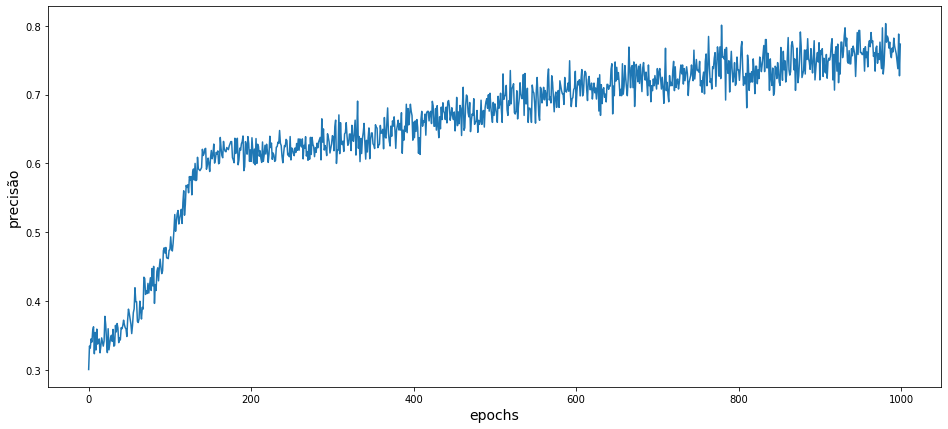

In [279]:
plt.figure(figsize=(16,7))
plt.xlabel("epochs", fontsize=14)
plt.ylabel("precisão", fontsize=14)
plt.plot(range(len(d_precision)), d_precision);

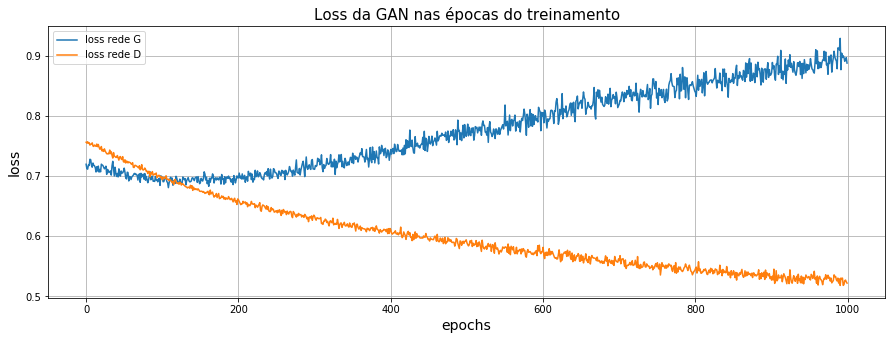

In [280]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(gloss)), gloss, label="loss rede G")
plt.plot(range(len(dloss)), dloss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

In [282]:
np.mean(obj_oc.D.predict_classes(X_nov)==1)

0.6624203821656051